# 붓꽃 분류 - Gaussian Naive Bayes 모델

이 글에서는 붓꽃의 꼳받침과 꽃잎의 특징을 사용하여 어떻게 꽃의 종류를 예측할 수 있는지 베이지안 추론 방식으로 보여줍니다. 이 글의 전개 과정은 아래와 같습니다. 

1. 붓꽃 데이터 세트를 준비합니다.
2. 꽃 종류별로 측정값의 히스토그램을 그려서 분포를 파악합니다.
3. 꽃 종류에 따라서 측정값이 어떻게 분포할 수 있는지 설명하는 모델을 정의합니다.
4. 측정값이 주어질 때 꽃의 종류를 예측하는 분류기를 구현합니다.
5. 데이터 세트를 훈련 데이터와 검증 데이터로 나누어 분류기를 훈련시키고 예측 성능을 구합니다.

## 라이브러리 준비

사용할 파이썬 라이브러리들을 임포트합니다.

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=6)
np.random.seed(7)

## 데이터 준비

**scikit-learn**에서 제공하는 API `load_iris()`를 사용하여 Iris 데이터 세트를 준비합니다.

* 붓꽃 세 종류에 대하여 종류별로 50개의 측정 데이터를 가짐
  * 꽃 종류
    * setosa
    * versicolor
    * virginica
  * 측정 항목
    * sepal length (cm): 꽃받침 길이
    * sepal width (cm): 꽃받침 넓이
    * petal length (cm): 꽃잎 길이
    * petal width (cm): 꽃잎 넓이

### 데이터 읽기

In [2]:
ds_iris = load_iris()

print(f'target names: {ds_iris.target_names}')
print(f'feature names: {ds_iris.feature_names}')
print(f'data shape: {ds_iris.data.shape}')
print(f'target shape: {ds_iris.target.shape}')

target names: ['setosa' 'versicolor' 'virginica']
feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
data shape: (150, 4)
target shape: (150,)


## 데이터 탐색

### 데이터 통계

측정 데이터 앞부분의 일부 내용은 다음과 같습니다.

In [3]:
df_data = pd.DataFrame(ds_iris.data, columns=ds_iris.feature_names)
df_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


측정 데이터별 통계 자료는 아래와 같습니다.

In [4]:
df_data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 꽃 종류별 측정값의 히스토그램

꽃 종류별로 측정값의 히스토그램을 그립니다. 이것을 참고하여 꽃 종류에 따라 측정값이 어떤 분포를 따르는지 추정할 수 있습니다.

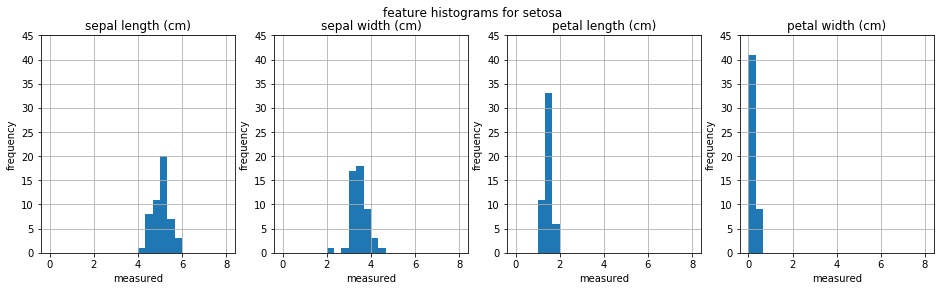

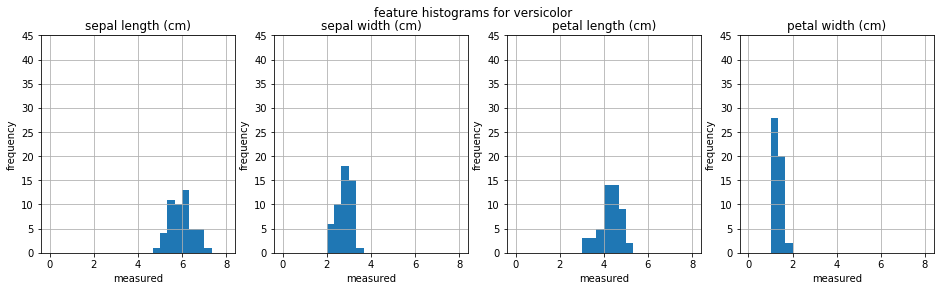

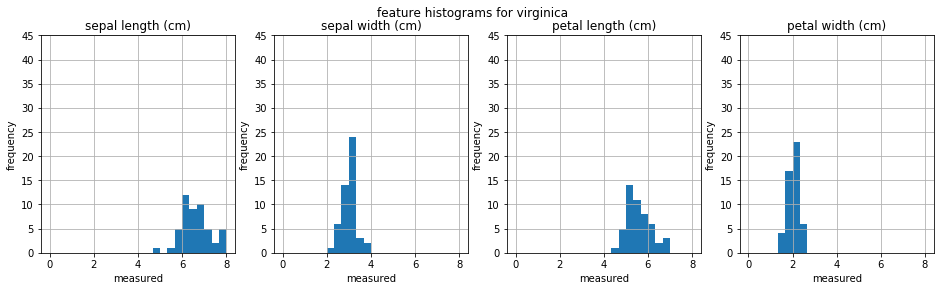

In [5]:
def separate_by_targets(X, y):
    separated = defaultdict(lambda: [])
    
    row_count = X.shape[0]
    for row in np.arange(row_count):
        measured = X[row, :]
        target = y[row]
        separated[target].append(measured)
    
    for target in separated.keys():
        separated[target] = np.array(separated[target])
        
    return separated

def plot_feature_histograms_for_a_target(separated, target, feature_names, target_name):
    ds_measured = separated[target]
    
    fig = plt.figure(figsize = (16,4))
    fig.suptitle(f'feature histograms for {target_name}')
    for col in np.arange(len(feature_names)):
        plt.subplot(141 + col)
        plt.hist(ds_measured[:, col], bins=24, range=(0, 8))
        plt.ylim(0, 45)
        plt.grid(True)
        plt.xlabel('measured')
        plt.ylabel('frequency')
        plt.title(feature_names[col])
    plt.show()
    
separated = separate_by_targets(ds_iris.data, ds_iris.target)
for target in np.arange(len(separated.keys())):
    feature_names = ds_iris.feature_names
    target_name = ds_iris.target_names[target]
    plot_feature_histograms_for_a_target(separated, target, feature_names, target_name)

위의 히스토그램을 토대로 꽃 종류별 측정값의 분포를 정규분포로 간주하는 것이 크게 무리는 아니라고 볼 수 있습니다.

### 꽃 종류별 측정값의 상자그림

꽃 종류에 따라 측정값의 통계가 어떻게 달라지는지 더 명확하게 파악하기 위하여 꽃 종류별로 측정값의 상자그림을 그려봅니다.

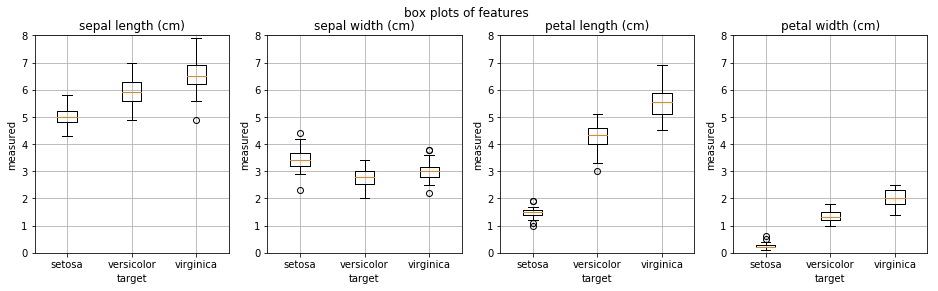

In [6]:
plt.figure(figsize = (16,4))
plt.suptitle('box plots of features')
for col in np.arange(len(ds_iris.feature_names)):
    plt.subplot(141 + col)
    data_for_boxplot = []
    labels = []
    for target in np.arange(len(separated.keys())):
        data_for_boxplot.append(separated[target][:, col])
        labels.append(ds_iris.target_names[target])
    plt.boxplot(data_for_boxplot, labels = labels)
    plt.ylim(0.0, 8.0)
    plt.grid(True)
    plt.xlabel('target')
    plt.ylabel('measured')
    plt.title(f'{ds_iris.feature_names[col]}')
plt.show()

위의 상자그림들을 살펴 보면 **setosa**의 경우 꽃잎 길이나 꽃잎 넓이 측정값만으로도 나머지 두 가지 꽃 종류와 완전하게 구분됨을 알 수 있습니다.

## 모델 정의

**꽃 종류에 따른 측정값의 분포**를 설명하기 위하여 모델을 정의합니다. 여기에서는 꽃 종류가 주어질 때 측정을 수행하여 얻는 값들의 발생 가능성이 아래의 분포를 따른다고 가정합니다.

* 조사대상군으로부터 수집한 데이터에서 구한 꽃 종류별 측정값 평균과 표준편차를 사용하는 정규분포

예를 들어 꽃 종류가 **setosa**일 때 꽃받침 길이에 해당하는 값들의 발생 가능성이 어떻게 분포하는지는 아래의 방법으로 구합니다.

1. 데이터 세트에서 **setosa**에 해당하는 것들만 따로 모읍니다.
2. 꽃받침 길이 값들의 평균과 표준편차를 구합니다.
3. 위에서 구한 평균과 표준편차를 사용하는 정규분포를 그립니다. 

이제 꽃 종류별 측정값 평균과 표준편차를 구하여 테이블 형태로 저장합니다.

In [7]:
def get_norm_params(separated):
    targets = separated.keys()
    target_count = len(targets)
    feature_count = separated[0].shape[1]

    thetas = np.zeros((target_count, feature_count))
    sigmas = np.zeros((target_count, feature_count))
    
    for target in targets:
        ds_measured = separated[target]
        thetas[target,:] = np.mean(ds_measured, axis=0)
        sigmas[target,:] = np.std(ds_measured, axis=0)
        
    return thetas, sigmas

thetas, sigmas = get_norm_params(separated)

위에서 구한 평균과 표준편차 값들을 사용하여 정규분포 곡선을 그려 봅니다.

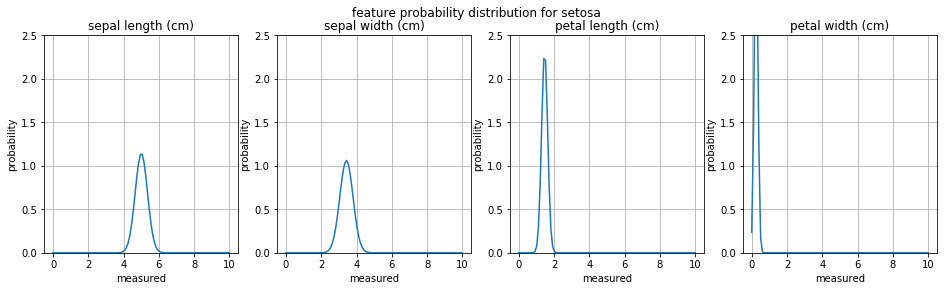

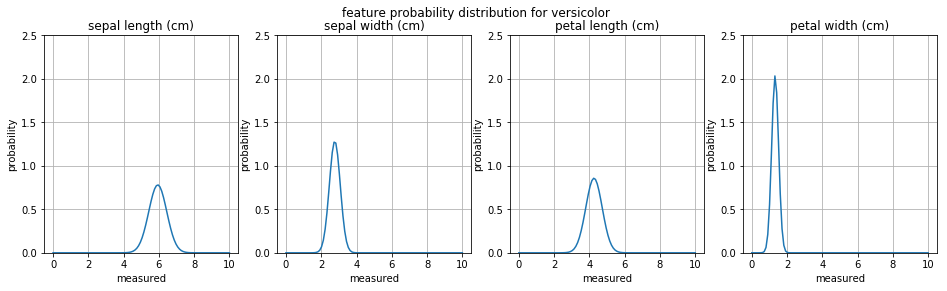

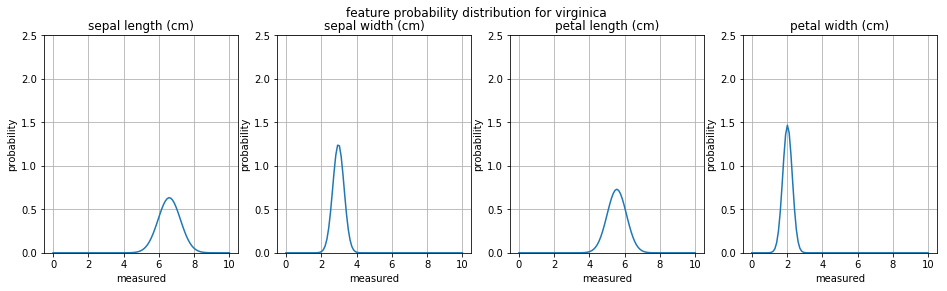

In [8]:
def plot_feature_norm_for_a_target(thetas, sigmas, target, feature_names, target_name):
    x_arr = np.linspace(0, 10, 100)
    
    fig = plt.figure(figsize = (16,4))
    fig.suptitle(f'feature probability distribution for {target_name}')
    for col in np.arange(len(feature_names)):
        y_arr = norm.pdf(x_arr, thetas[target, col], sigmas[target, col])
        plt.subplot(141 + col)
        plt.plot(x_arr, y_arr)
        plt.ylim(0.0, 2.5)
        plt.grid(True)
        plt.xlabel('measured')
        plt.ylabel('probability')
        plt.title(feature_names[col])
    plt.show()
    
for target in np.arange(len(separated.keys())):
    feature_names = ds_iris.feature_names
    target_name = ds_iris.target_names[target]
    plot_feature_norm_for_a_target(thetas, sigmas, target, feature_names, target_name)

## 베이지안 추론

베이즈 정리에 기반하여 다음과 같이 세 단계를 거쳐 추론하는 것을 베이지안 추론이라고 합니다.

1. 기존의 믿음 (prior belief)
2. 새로운 증거 (new evidence)
3. 믿음의 수정 (update belief -> posterior belief)

### 베이즈 정리

베이즈 정리는 아래의 식으로 표현됩니다.

* $P(H|E) = \frac{P(E|H)\times P(H)}{P(E)}$

위 식에서 각 항목의 의미는 다음과 같습니다.

* $E$ : 사건 (event)
* $H$ : 추론하고자 하는 값 (hypothesis)
* $P(H)$ : E가 발생하기 전의 H에 대한 확률분포 (prior probability distribution)
* $P(E|H)$ : H를 알고 있을 때 E의 발생 가능도 (likelihood)
* $P(E)$ : H에 관계없이 E의  발생 가능도 (marginal likelihood)
* $P(H|E)$ : E가 발생한 후의 H에 대한 확률분포 (posterior probability distribution)

위의 식을 붓꽃 종류 분류 문제에 적용하기 위하여 E와 H를 다음과 같이 정의합니다.

* E: 측정값 ($v_{measured}$)
* H: 측정값으로부터 추정하는 실제값 ($v_{actual}$)

측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$의 확률분포를 아래와 같이 조건부확률로 표현할 수 있습니다.

* $P(v_{actual}|v_{measured})$

이를 베이즈 정리에 따라 표현하면 아래와 같습니다.

* $P(v_{actual}|v_{measured})=\frac { P(v_{measured}|v_{actual})\times P(v_{actual}) }{ P(v_{measured}) }$

위 식의 각 항목에 대한 의미는 다음과 같습니다.

* $P(v_{actual})$ : 측정값을 알기 전의 실제값 $v_{actual}$에 대한 확률분포
* $P(v_{measured}|v_{actual})$ : 실제값이 $v_{actual}$일때 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{measured})$ : 실제값이 무엇이냐에 관계없이 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{actual}|v_{measured})$ : 측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$에 대한 확률분포

### 기존의 믿음

붓꽃 데이터 세트로부터 얻은 꽃 종류의 분포를 기존의 믿음으로 간주합니다. 즉 꽃 종류가 알려지지 않은 새로운 붓꽃이 주어질 때 꽃받침과 꽃잎의 길이와 넓이를 측정하기 전에는 그 꽃의 종류는 데이터 세트로부터 얻은 분포를 따른다고 믿는 것입니다. 이를 **사전확률(prior probability)**이라고 합니다.

In [9]:
def get_priors(separated):
    targets = separated.keys()

    priors = np.zeros(len(targets))
    
    total_count = 0
    for target in targets:
        count = separated[target].shape[0]
        total_count += count
        priors[target] = count
    
    priors /= total_count
    
    return priors

priors = get_priors(separated)
print(priors)

[0.333333 0.333333 0.333333]


위의 결과는 주어진 붓꽃에 대하여 측정을 하기 전까지는 아래의 확률로 꽃 종류를 추정할 수 있음을 의미합니다.

* $P(target=setosa) = \frac {1}{3}$
* $P(target=versicolor) = \frac {1}{3}$
* $P(target=verginica) = \frac {1}{3}$

### 새로운 증거

붓꽃 한 개가 있고 꽃받침의 길이와 넓이, 그리고 꽃잎의 길이와 넓이를 측정하여 얻은 값은 다음과 같다고 가정합니다.

| 꽃받침 길이(sl) | 꽃받침 넓이(sw) | 꽃잎 길이(pl) | 꽃잎 넓이(pw) |
| -- | -- | -- | -- |
| 6.1 | 3.3 | 5.1 | 1.4 |

In [10]:
measured = np.array([[6.1, 3.3, 5.1, 1.4]])

실제값이 $target = t$일 때 측정값 $sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}$을 얻을 가능성을 나타내는 **가능도(likelihood)**를 구합니다. 이때 각각의 특성은 서로 독립적이라고 가정하고 특성별로 확률을 계산합니다. 이러한 가정을 하기 때문에 **Bayes** 방식이라는 말 앞에 **Naive**를 덧붙여서 부릅니다. 

* $P(sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}|target=t) = \\
\qquad P(sl=m_{sl}|target=t) \times \\
\qquad P(sw=m_{sw}|target=t) \times \\
\qquad P(pl=m_{pl}|target=t) \times \\
\qquad P(pw=m_{pw}|target=t)$

In [11]:
def get_likelihoods(thetas, sigmas, measured):
    target_count = thetas.shape[0]
    instance_count = measured.shape[0]

    likelihoods = np.zeros((instance_count, target_count))
    
    for target in np.arange(target_count):
        l = norm.pdf(measured, thetas[target, :], sigmas[target, :])
        likelihoods[:, target] = np.prod(l, axis=1)
        
    return likelihoods

likelihoods = get_likelihoods(thetas, sigmas, measured)
print(likelihoods)

[[1.165488e-125 7.080827e-002 1.870655e-002]]


실제값이 무엇인지에 관계없이 측정값으로 $sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}$을 얻을 가능성을 나타내는 **주변가능도(marginal likelihood)**는 아래와 같이 구합니다.

* $P(sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}) = \\
\qquad P(sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}|target=0) \times P(target=0) + \\
\qquad P(sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}|target=1) \times P(target=1) + \\
\qquad P(sl=m_{sl};sw=m_{sw};pl=m_{pl};pw=m_{pw}|target=2) \times P(target=2)$

In [12]:
marginal_likelihoods = np.sum(likelihoods * priors, axis=1)
print(marginal_likelihoods)

[0.029838]


### 믿음의 수정

**새로운 증거(new evidence)**를 활용하여 **기존의 믿음(prior)**을 수정합니다. 이렇게 얻은 확률을 **사후확률 (posterior)**이라고 부릅니다. 측정값이 주어진 상태에서 꽃종류를 바꾸어 가면서 사후확률을 구합니다.

In [13]:
def get_posteriors(priors, thetas, sigmas, X):
    likelihoods = get_likelihoods(thetas, sigmas, X)
    marginal_likelihoods = np.sum(likelihoods * priors, axis=1)
    likelihood_ratios = likelihoods / marginal_likelihoods.reshape(len(marginal_likelihoods), -1)
    posteriors = likelihood_ratios * priors
    return posteriors

posteriors = get_posteriors(priors, thetas, sigmas, measured)
print(posteriors)

[[1.302006e-124 7.910229e-001 2.089771e-001]]


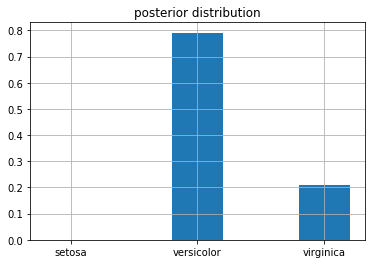

In [14]:
plt.figure(figsize = (6, 4))
plt.bar(ds_iris.target_names, posteriors[0,:], width=0.4)
plt.grid(True)
plt.title('posterior distribution')
plt.show()

 꽃 종류별 사후확률 중에서 최대 사후확률에 해당하는 꽃 종류를 실제값으로 간주합니다. 이 과정을 **Maximum A Posteriori(MAP) 추정**이라고 부릅니다.

In [15]:
predicted = np.argmax(posteriors, axis=1)

for i in np.arange(measured.shape[0]):
    print(f'{measured[i,:]} => {ds_iris.target_names[predicted[i]]}')

[6.1 3.3 5.1 1.4] => versicolor


## 분류기 구현

위에서 정의한 함수들을 사용하여 분류기 클래스를 아래와 같이 구현할 수 있습니다.

In [16]:
class GaussianNB:
    def fit(self, X, y):
        # separate by targets
        separated = separate_by_targets(X, y)
        
        # get priors
        self.priors = get_priors(separated)
        
        # get normal distribution parameters
        self.thetas, self.sigmas = get_norm_params(separated)
        
    def predict(self, X):
        posteriors = get_posteriors(self.priors, self.thetas, self.sigmas, X)
        predicted = np.argmax(posteriors, axis=1)
        return predicted
        
    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

### 예측 성능

In [17]:
X, y = ds_iris.data, ds_iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

nb = GaussianNB()
nb.fit(X_train, y_train)

score = nb.score(X_test, y_test)
print(f'score = {score:.4f}')

score = 0.8333


## 마무리

* 이 글에서 구현한 분류기는 측정값이 정규분포를 따르는 다른 종류의 데이터 세트에 대해서도 동작합니다.